In [24]:
import pandas as pd
import os
import geopandas as gpd
import geoplot
import geoplot.crs as gcrs
import matplotlib.pyplot as plt
import rasterio
from statsmodels.tsa.seasonal import STL
import numpy as np
from sklearn.linear_model import LinearRegression
import datetime as dt
from matplotlib.colors import TwoSlopeNorm
import time
from rasterstats import zonal_stats
from scipy.stats import pearsonr
import plotly.express as px

sys.path.append(os.path.abspath("c:\\Users\\Jesse\\OneDrive\\Documenten\\Master BAOR\\Thesis\\GitHub\\dicra\\analytics\\sandbox\\notebooks\\crop_fires\\Functions"))
import dppd
import Preprocess

In [25]:
os.chdir('c:\\Users\\Jesse\\OneDrive\\Documenten\\Master BAOR\\Thesis\\GitHub\\dicra\\src\\data_preprocessing\\tsdm\\')
mandal_boundaries = gpd.read_file('Mandal_Boundary.shp')
mandal_boundaries = mandal_boundaries.reset_index()

os.chdir('c:\\Users\\Jesse\\OneDrive\\Documenten\\Master BAOR\\Thesis\\GitHub\\dicra\\src\\data_preprocessing\\tsdm\\')
district_boundaries = gpd.read_file('District_Boundary.shp')
district_boundaries = district_boundaries.reset_index()

os.chdir('c:\\Users\\Jesse\\OneDrive\\Documenten\\Master BAOR\\Thesis\\GitHub\\dicra\\src\\data_preprocessing\\base_geojson')
shape_telangana = gpd.read_file('TL_state_shapefile_for_clip.geojson')
shape_telangana = shape_telangana.explode()


In [26]:
#Load needed format for Dicra
os.chdir('c:\\Users\\Jesse\\OneDrive\\Documenten\\Master BAOR\\Thesis\\GitHub\\dicra\\src\\data_preprocessing\\base_geojson')
mandal = gpd.read_file('TS_mandal_boundary.json')
district = gpd.read_file('TS_district_boundary.json')

In [27]:
import importlib
importlib.reload(dppd)
importlib.reload(Preprocess)

<module 'Preprocess' from 'c:\\Users\\Jesse\\OneDrive\\Documenten\\Master BAOR\\Thesis\\GitHub\\dicra\\analytics\\sandbox\\notebooks\\crop_fires\\Functions\\Preprocess.py'>

In [34]:
os.chdir('c:\\Users\\Jesse\\OneDrive\\Documenten\\Master BAOR\\Thesis\\GitHub\\dicra\\analytics\\sandbox\\notebooks\\crop_fires\\Data_csv\\results_csv')
df_PM2_5_dis = pd.read_csv('PM2.5_District.csv', index_col=0)
df_PM2_5_man = pd.read_csv('PM2.5_Mandal.csv', index_col=0)

In [29]:
df_PM2_5_dis['ModifiedDateTime'] = pd.to_datetime(df_PM2_5_dis['ModifiedDateTime'])
df_PM2_5_man['ModifiedDateTime'] = pd.to_datetime(df_PM2_5_man['ModifiedDateTime'])

print('Available Years: ' + str(df_PM2_5['ModifiedDateTime'].dt.year.unique()))

Available Years: [2015 2016 2017 2018 2019 2020]


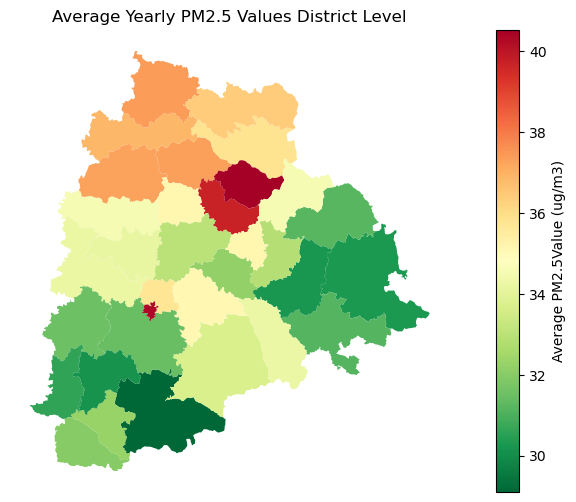

In [30]:
dppd.create_avg_plot(df_PM2_5_dis, 2015, 2020, 'PM2.5', 'District', 'ug/m3')

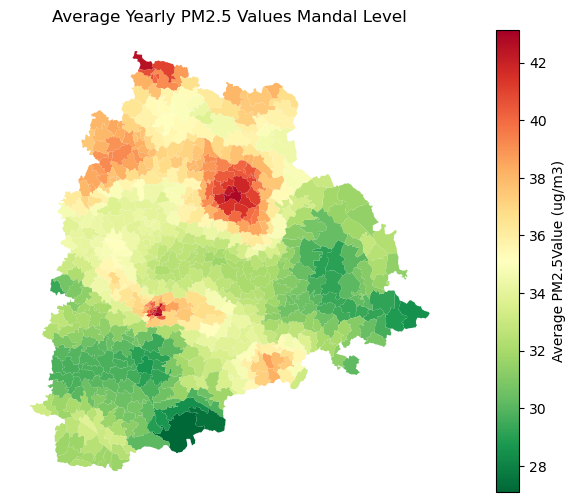

In [31]:
dppd.create_avg_plot(df_PM2_5_man, 2015, 2020, 'PM2.5', 'Mandal', 'ug/m3')

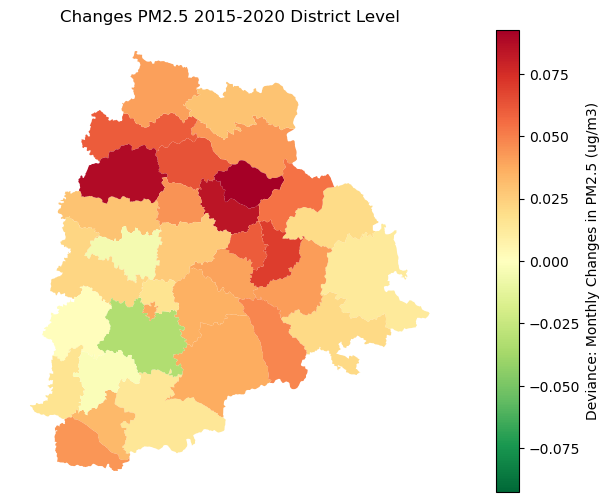

File is saved.


In [32]:
figure, df_DPPD_PM2_5_2015_2020_district = dppd.dppd_general(df_PM2_5_dis, 2015, 2020, 'PM2.5', district_boundaries, 'District', 'ug/m3')

dppd.save_dicra(df_DPPD_PM2_5_2015_2020_district, district_boundaries, district, 'DPPD_PM2_5_District_2015_2020_dicra', 'District')

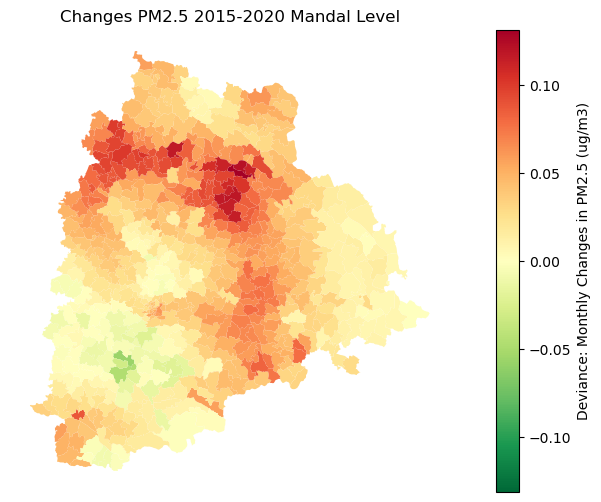

File is saved.


In [33]:
figure, df_DPPD_PM2_5_2015_2020_mandal = dppd.dppd_general(df_PM2_5_man, 2015, 2020, 'PM2.5', mandal_boundaries, 'Mandal', 'ug/m3')

dppd.save_dicra(df_DPPD_PM2_5_2015_2020_mandal, mandal_boundaries, mandal, 'DPPD_PM2_5_Mandal_2015_2020_dicra', 'Mandal')